# TODO
- [ ] Redo exploration with the full DF, not the sample
- [ ] Maybe try to square logerror to get rid of the negatives. Does it really matter whether the logerror is positive or negative? If it's +, the Zestimate was too high. If it's -, the Zestimate was too low.
- [ ] try to standardize the variables. normalize the training data and use the min and max from the training data to normalize the test data. do it with pandas
- [ ] look at transaction date vs. logerror
- [ ] try to bin the data
- [x] remove outliers that are more than 2.5 STDs from mean
- [ ] look at sk-learn impute function to impute missing values instead of throwing out rows with NaNs
- [ ] There are multiple rows with the same parcelid. drop them because there aren't that many and i don't know which row has the correct data, although they may be duplicates.
- [ ] There are properties with a 0.0 bathroomcnt, but there are no properties with 0.0 for fullbathcnt; but there are no properties with 0.0 bathroomcnt and greater than 0 fullbathcnt
- [ ] drop roomcnt column. it has 69,700 rows with 0 rooms. this can't be if they are houses
- [ ] drop garagecarcnt column because it has too many NaNs
- [ ] drop fullbathcnt column because bathroomcnt probably provides richer info
- [ ] feature engineer yearbuilt to where i find the distance between the mean and the year built
- [ ] what are the features that are driving the logerror up or down?
- [ ] use the t-test results to run a regression model on both of the two groups. E.g., run a regression model on X_train rows with bedroomcnt == 3 and bedroomcnt = 5+, etc

# Domain Knowledge
* Studio apartments usually have one room and one bath. Source is written as if a studio has 0 bedrooms, but 1 room. A one bedroom apartment has one bedroom. [Source](https://homeguides.sfgate.com/difference-between-studio-single-apartment-2598.html).

# Zillow Regression Project

## Project Planning

### Goals
Zillow wants you to develop a model to predict the error between the Zestimate and the sales price of a home. In predicting the error, you will discover features that will help them improve the Zestimate estimate itself. Your goal of this project is to develop a linear regression model that will best predict the log error of the Zestimate.

### Deliverables

1. A report (in the form of a presentation, both verbal and through a slides) that summarizes your findings about the drivers of the Zestimate error. This will come from the analysis you do during the exploration phase of the pipeline. In the report, you will have charts that visually tell the story of what is driving the errors.

1. A Jupyter notebook, titled 'Regression_Proj_YourName', that contains a clearly labeled section and code clearly documented for each the stages below (project planning, data acquisition, data prep, exploration, and modeling). All of the work will take place in your jupyter notebook.


### Data Dictionary & Details

* logerror
* bathroomcnt: Number of bathrooms in home including fractional bathrooms
* bedroomcnt: Number of bedrooms in home 
* calculatedfinishedsquarefeet: Calculated total finished living area of the home
* fullbathcnt: Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
* garagecarcnt: Total number of garages on the lot including an attached garage
* roomcnt: Total number of rooms in the principal residence
* yearbuilt: The Year the principal residence was built 
* taxvaluedollarcnt: The total tax assessed value of the parcel
* taxamount: The total property tax assessed for that assessment year

We are predicting the error (residual). The log of the error. Log base 10. Customer is Zillow data scientists
We will be presenting to data scientists. 3-4 minutes. Can be technical. Not limited to a single slide

Use 2016 data (do not use properties_2017 or predictions_2017)

filter out any from prediction2_2016 that do no have a logerror

may want to add regionidzip (optional)

we are targeting properties and houses

missing values
    - may want to replace with 0 if it makes sense
    - drop columns with missing values (e.g., 50% missing)
    - drop row if there are a few rows with missing values
    - if 0 bed and 0 baths, it may be a lot. look at calculatedfinishedsquarefeet, which is for houses
    
sk-learn impute()

min-max normalization. we make the min to 0 and the max to 1. normalizing the data is a bonus, to compare and contrast with not normalizing
    - (x-min)/(max-min)
    
put path to csv files in env.py file

### Initial Thoughts, Ideas, Hypotheses
dependent/target variable:
* logerror: $logerror=log(Zestimate)−log(SalePrice)$

independent variables/regressors:
* \# of bathrooms
* \# of bedrooms
* square footage
* \# of full bathrooms
* \# of garages
* \# of rooms
* year built
* tax roll estimate
* property tax amount

### Hypotheses
* number of bedrooms and number of bathrooms are correlated
* square footage and number of rooms are correlated
* tax roll estimate and property tax amount are correlated
* number of bathroom and number of full bathrooms are giving largely the same amount of information. number of bathrooms is probably giving more information because it includes half bathrooms
* year built is not correlated with tax roll estimate
* tax roll estimate is correlated with logerror because this can be overinflated or underinflated
* number of full bathroom is correlated with logerror because it does not capture partial bathrooms
* year built is correlated with logerror because it does not have an influence on price (people pay a lot of money for new and old houses)
* property tax amount is correlated with logerror because it can be contested and it is also influenced by the rates of local jurisdictions
* number of garages is correlated with logerror because it may not be relevant to the sales price

### Questions
* Does the number of garages actually measure the number of garages or the number of cars that can be garaged?

## Prepare Environment

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression

from env import csv_properties_path, csv_train_path

## Helper Functions

In [6]:
import io

def df_metadata(df) -> tuple:
    """
    return a tuple of (size, shape, info)
    """
    buffer = io.StringIO()
    df.info(buf=buffer)
    return (df.size, df.shape, buffer.getvalue())


def df_print_metadata(df) -> None:
    """
    print metadata of dataframe
    """
    size, shape, info = df_metadata(df)
    print("DATAFRAME METADATA")
    print(f"Size: {size}")
    print()
    print(f"Shape: {shape[0]} x {shape[1]}")
    print()
    print("Info:")
    print(info, end="")


def df_peek(df) -> tuple:
    """
    return head and tail of df
    """
    return df.head().append(df.tail())

def df_print_summary(df, columns=[]):
    """
    columns is a sequence of columns whose IQR and range will be calculated
    """
    if not columns:
        columns = df.columns
    print("SUMMARY")
    description = df.describe()
    print("Description:")
    print(description)
    print()
    print("IQR:")
    for col in columns:
        print(f"\t{col}: {description.loc['75%', col] - description.loc['25%', col]}")
    print()
    print("Range:")
    for col in columns:
        print(f"\t{col}: {df[col].max() - df[col].min()}")

def series_is_whole_nums(series):
    try:
        return (series % 1 == 0).all()
    except TypeError:
        return False

def df_float_to_int(df):
    to_coerce = {}
    for col in df.columns:
        if series_is_whole_nums(df[col]):
              to_coerce[col] = int
    return df.astype(to_coerce)
              
def df_print_missing_vals(df):
    # any missing values?
    print("\nMissing Values:\n")
    null_counts = df.isnull().sum()
    if len(null_counts[null_counts > 0]) == 0:
        print("No missing values")
    else:
        print(null_counts[null_counts > 0])
              
def df_percent_missing_vals(df):
    return (df.isnull().sum() / df.shape[0]) * 100
              
def df_drop_cols(df, to_drop):
    return df.drop(columns=to_drop)
              
def df_remove_outliers(df, cols, zscore_limit):
    df_clean = None
    for col in cols:
        df_clean = df[(np.abs(stats.zscore(df[cols])) < zscore_limit).all(axis=1)]
    return df_clean

## Data Acquisition

In [3]:
# read CSV containing property data
df_props_raw = pd.read_csv(csv_properties_path)

### Summarize Data

In [7]:
df_peek(df_props_raw)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,168040430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_print_metadata(df_props_raw)

DATAFRAME METADATA
Size: 173142586

Shape: 2985217 x 58

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt              

In [9]:
# read CSV containing logerror data for properties
df_error_raw = pd.read_csv(csv_train_path)

In [10]:
df_print_metadata(df_error_raw)

DATAFRAME METADATA
Size: 270825

Shape: 90275 x 3

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
parcelid           90275 non-null int64
logerror           90275 non-null float64
transactiondate    90275 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


In [11]:
df_peek(df_error_raw)

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02
90270,10774160,-0.0356,2016-12-30
90271,12046695,0.0070,2016-12-30
90272,12995401,-0.2679,2016-12-30
90273,11402105,0.0602,2016-12-30
90274,12566293,0.4207,2016-12-30


In [12]:
df_error_raw.describe()

,parcelid,logerror
count,9.027500e+04,90275.000000
mean,1.298466e+07,0.011457
std,2.504510e+06,0.161079
min,1.071174e+07,-4.605000
25%,1.155950e+07,-0.025300
50%,1.254734e+07,0.006000
75%,1.422755e+07,0.039200
max,1.629608e+08,4.737000


## Data Preparation

In [13]:
# take only the relevant columns from property DF
colnames = ["parcelid", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet", "fullbathcnt",
                  "garagecarcnt", "roomcnt", "yearbuilt", "taxvaluedollarcnt", "taxamount",]
df_props = df_props_raw[colnames]


In [14]:
# Merge property and logerror info into one DF
df_props_error = df_props.merge(df_error_raw, on="parcelid", how="inner")

In [15]:
df_peek(df_props_error)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,17073783,2.5,3.0,1264.0,2.0,2.0,5.0,1986.0,191811.0,2015.06,0.0953,2016-01-27
1,17088994,1.0,2.0,777.0,1.0,1.0,4.0,1990.0,239679.0,2581.30,0.0198,2016-03-30
2,17100444,2.0,3.0,1101.0,2.0,2.0,5.0,1956.0,47853.0,591.64,0.0060,2016-05-27
3,17102429,1.5,2.0,1554.0,1.0,2.0,5.0,1965.0,62914.0,682.78,-0.0566,2016-06-07
4,17109604,2.5,4.0,2415.0,2.0,2.0,8.0,1984.0,554000.0,5886.92,0.0573,2016-08-08
90270,11876798,3.0,4.0,2068.0,3.0,NaN,0.0,2008.0,596082.0,7335.81,0.0276,2016-04-15
90271,12808516,2.0,3.0,1352.0,2.0,NaN,0.0,1956.0,178408.0,2441.74,-0.1188,2016-06-07
90272,12010248,2.0,2.0,860.0,2.0,NaN,0.0,2011.0,420000.0,5070.41,0.0843,2016-06-30
90273,14310905,2.5,3.0,2268.0,2.0,2.0,0.0,2012.0,1215816.0,12508.30,-0.0050,2016-03-31
90274,14636609,2.5,3.0,1812.0,2.0,2.0,0.0,2013.0,471286.0,5470.12,0.0129,2016-09-13


In [16]:
df_print_metadata(df_props_error)

DATAFRAME METADATA
Size: 1083300

Shape: 90275 x 12

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 12 columns):
parcelid                        90275 non-null int64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
garagecarcnt                    29937 non-null float64
roomcnt                         90275 non-null float64
yearbuilt                       89519 non-null float64
taxvaluedollarcnt               90274 non-null float64
taxamount                       90269 non-null float64
logerror                        90275 non-null float64
transactiondate                 90275 non-null object
dtypes: float64(10), int64(1), object(1)
memory usage: 9.0+ MB


### Address Missing Values

In [17]:
df_print_missing_vals(df_props_error)


Missing Values:

calculatedfinishedsquarefeet      661
fullbathcnt                      1182
garagecarcnt                    60338
yearbuilt                         756
taxvaluedollarcnt                   1
taxamount                           6
dtype: int64


In [18]:
# % of NaNs in columns
df_percent_missing_vals(df_props_error)

parcelid                         0.000000
bathroomcnt                      0.000000
bedroomcnt                       0.000000
calculatedfinishedsquarefeet     0.732207
fullbathcnt                      1.309333
garagecarcnt                    66.837995
roomcnt                          0.000000
yearbuilt                        0.837441
taxvaluedollarcnt                0.001108
taxamount                        0.006646
logerror                         0.000000
transactiondate                  0.000000
dtype: float64

In [19]:
# drop garagecarcnt, roomcnt, and fullbathcnt
to_drop = ["garagecarcnt", "roomcnt", "fullbathcnt"]
df_dropped = df_drop_cols(df_props_error, to_drop)
df_peek(df_dropped)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,17073783,2.5,3.0,1264.0,1986.0,191811.0,2015.06,0.0953,2016-01-27
1,17088994,1.0,2.0,777.0,1990.0,239679.0,2581.30,0.0198,2016-03-30
2,17100444,2.0,3.0,1101.0,1956.0,47853.0,591.64,0.0060,2016-05-27
3,17102429,1.5,2.0,1554.0,1965.0,62914.0,682.78,-0.0566,2016-06-07
4,17109604,2.5,4.0,2415.0,1984.0,554000.0,5886.92,0.0573,2016-08-08
90270,11876798,3.0,4.0,2068.0,2008.0,596082.0,7335.81,0.0276,2016-04-15
90271,12808516,2.0,3.0,1352.0,1956.0,178408.0,2441.74,-0.1188,2016-06-07
90272,12010248,2.0,2.0,860.0,2011.0,420000.0,5070.41,0.0843,2016-06-30
90273,14310905,2.5,3.0,2268.0,2012.0,1215816.0,12508.30,-0.0050,2016-03-31
90274,14636609,2.5,3.0,1812.0,2013.0,471286.0,5470.12,0.0129,2016-09-13


In [20]:
# remove rows with NaNs
df_nanless = df_dropped.dropna()
print(f"Dropped {df_dropped.shape[0] - df_nanless.shape[0]} rows.")
print()
df_print_metadata(df_nanless)

Dropped 776 rows.

DATAFRAME METADATA
Size: 805491

Shape: 89499 x 9

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89499 entries, 0 to 90274
Data columns (total 9 columns):
parcelid                        89499 non-null int64
bathroomcnt                     89499 non-null float64
bedroomcnt                      89499 non-null float64
calculatedfinishedsquarefeet    89499 non-null float64
yearbuilt                       89499 non-null float64
taxvaluedollarcnt               89499 non-null float64
taxamount                       89499 non-null float64
logerror                        89499 non-null float64
transactiondate                 89499 non-null object
dtypes: float64(7), int64(1), object(1)
memory usage: 6.8+ MB


### Fix Data Types for Variables

In [21]:
# Convert variables to proper type
df_type_fix = df_float_to_int(df_nanless)
df_print_metadata(df_type_fix)

DATAFRAME METADATA
Size: 805491

Shape: 89499 x 9

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89499 entries, 0 to 90274
Data columns (total 9 columns):
parcelid                        89499 non-null int64
bathroomcnt                     89499 non-null float64
bedroomcnt                      89499 non-null int64
calculatedfinishedsquarefeet    89499 non-null int64
yearbuilt                       89499 non-null int64
taxvaluedollarcnt               89499 non-null int64
taxamount                       89499 non-null float64
logerror                        89499 non-null float64
transactiondate                 89499 non-null object
dtypes: float64(3), int64(5), object(1)
memory usage: 6.8+ MB


**Create a list of the independent variable names (aka attributes) and assign it to x_vars**

Why? During exploration, you will likely use this list to refer to the attribute names.


In [22]:
x_vars = ["bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet", "yearbuilt",
          "taxvaluedollarcnt", "taxamount"]

### Remove Outliers

In [23]:
# remove outliers that are more than 2.5 STDs from mean
df_no_outliers = df_remove_outliers(df_type_fix, x_vars, 2.5)
print(f"Removed {df_type_fix.shape[0] - df_no_outliers.shape[0]} rows with outliers.")
print()

Removed 6301 rows with outliers.



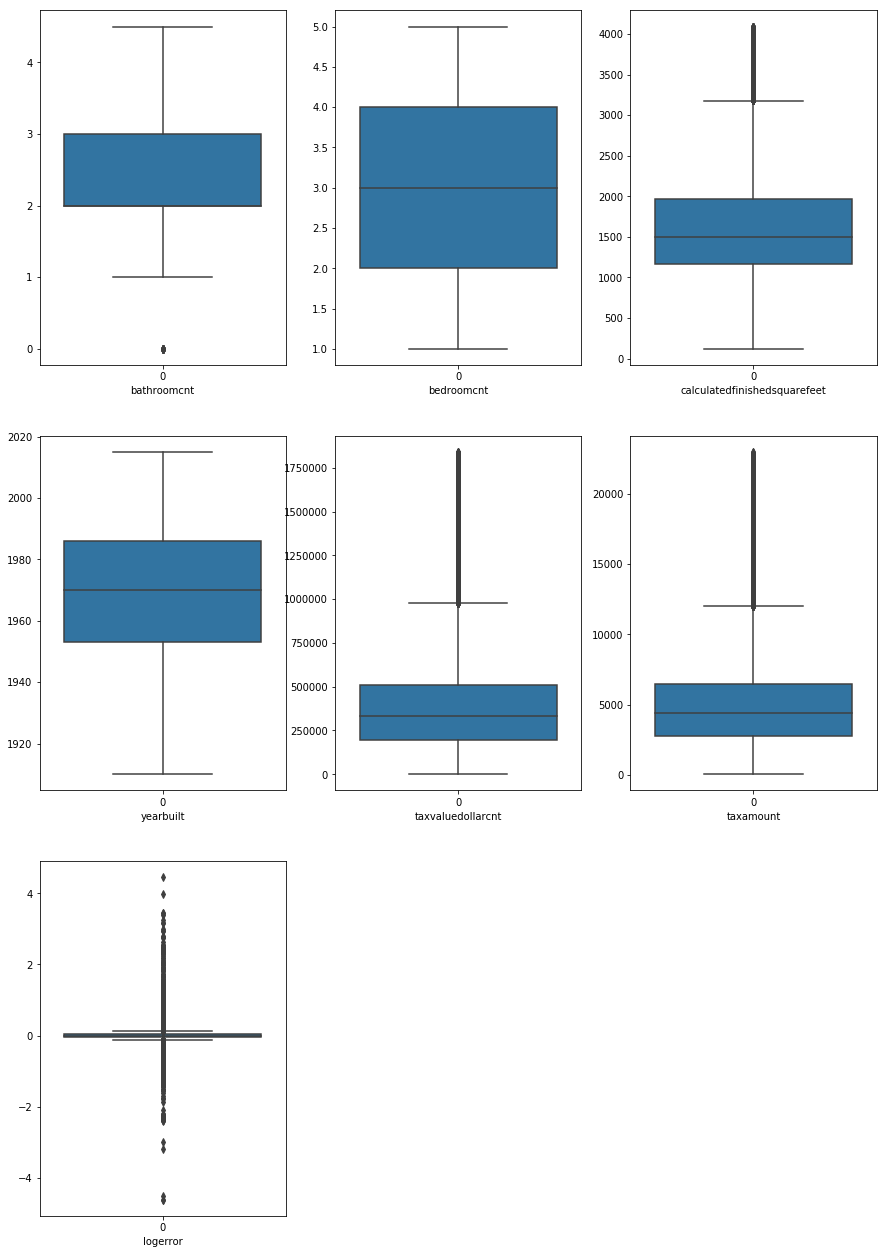

In [24]:
# boxplot the variables
plt.figure(figsize=(15, 30))
for i, var in enumerate(x_vars + ["logerror"]):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(data=df_no_outliers[var])
    plt.xlabel(var)
    #plt.yscale("log")
plt.show()

**Dependent Variable**
logerror. It is continuous.

**Distribution of numeric variables**

plot a histogram and box plot of each variable.
Why? To see the distribution, skewness, outliers, and unit scales. You will use this information in your decision of whether to normalize, standardize or neither.

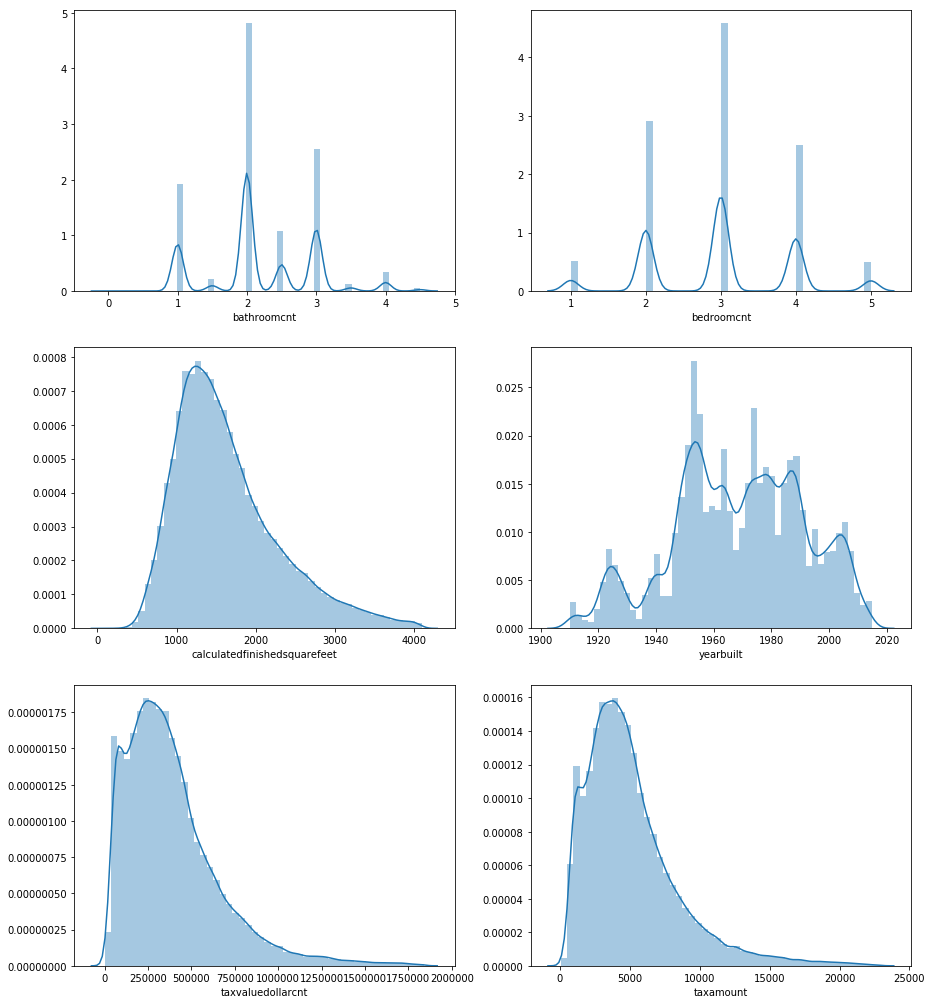

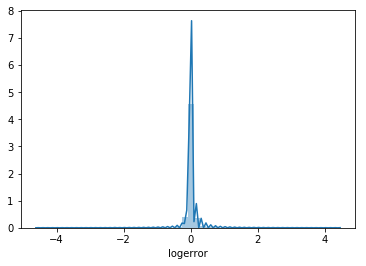

In [26]:
plt.figure(figsize=(15, 30))
for i, var in enumerate(x_vars):
    plt.subplot(5, 2, i + 1)
    sns.distplot(df_no_outliers[var])
    plt.xlabel(var)
plt.show()
    
sns.distplot(df_no_outliers.logerror)
plt.show()

### Take absolute value of logerror

In [31]:
df_abs_logerror = df_no_outliers.assign(logerror=df_no_outliers.logerror.abs())
df_abs_logerror

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,17073783,2.5,3,1264,1986,191811,2015.06,0.0953,2016-01-27
1,17088994,1.0,2,777,1990,239679,2581.30,0.0198,2016-03-30
2,17100444,2.0,3,1101,1956,47853,591.64,0.0060,2016-05-27
3,17102429,1.5,2,1554,1965,62914,682.78,0.0566,2016-06-07
4,17109604,2.5,4,2415,1984,554000,5886.92,0.0573,2016-08-08
5,17125829,2.5,4,2882,1980,289609,3110.44,0.0564,2016-08-26
6,17132911,2.0,3,1772,1978,526000,5632.20,0.0315,2016-07-08
7,17134926,2.5,5,2632,1971,571086,6109.94,0.0257,2016-05-11
8,17139988,2.0,3,1292,1979,462594,5026.40,0.0020,2016-06-15
9,17167359,1.0,3,1385,1950,268502,3217.06,0.0576,2016-05-27


## Exploration

**Split data into training and test datasets**

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_abs_logerror[x_vars], df_abs_logerror["logerror"], train_size=0.8, random_state=123)
print(X_train.info())
print()
print(X_test.info())
print()
print(y_train.shape)
print()
print(y_test.shape)
print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66558 entries, 22353 to 17006
Data columns (total 6 columns):
bathroomcnt                     66558 non-null float64
bedroomcnt                      66558 non-null int64
calculatedfinishedsquarefeet    66558 non-null int64
yearbuilt                       66558 non-null int64
taxvaluedollarcnt               66558 non-null int64
taxamount                       66558 non-null float64
dtypes: float64(2), int64(4)
memory usage: 3.6 MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16640 entries, 41478 to 34318
Data columns (total 6 columns):
bathroomcnt                     16640 non-null float64
bedroomcnt                      16640 non-null int64
calculatedfinishedsquarefeet    16640 non-null int64
yearbuilt                       16640 non-null int64
taxvaluedollarcnt               16640 non-null int64
taxamount                       16640 non-null float64
dtypes: float64(2), int64(4)
memory usage: 910.0 KB
None

(66558,)

(16640,)

**Jointplot for each independent variable (normalized version) with the dependent variable**

Pearson's r and p-value annotated on each plot

In [51]:
X_train.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt,taxamount
count,66558.000000,66558.000000,66558.000000,66558.000000,6.655800e+04,66558.000000
mean,2.184426,2.958337,1636.224736,1968.776556,3.885034e+05,5101.088231
std,0.760853,0.924363,655.276362,22.825219,2.767789e+05,3364.180930
min,0.000000,1.000000,120.000000,1910.000000,2.200000e+01,49.080000
25%,2.000000,2.000000,1163.000000,1953.000000,1.938390e+05,2804.720000
50%,2.000000,3.000000,1495.000000,1970.000000,3.321530e+05,4402.705000
75%,3.000000,4.000000,1968.000000,1986.000000,5.074142e+05,6495.057500
max,4.500000,5.000000,4091.000000,2015.000000,1.840000e+06,22976.050000


/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local

<Figure size 720x360 with 0 Axes>

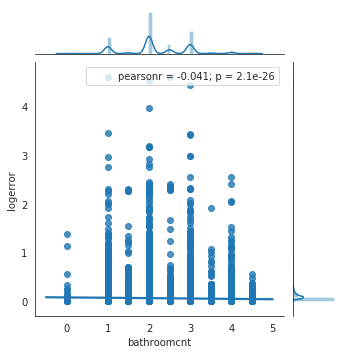

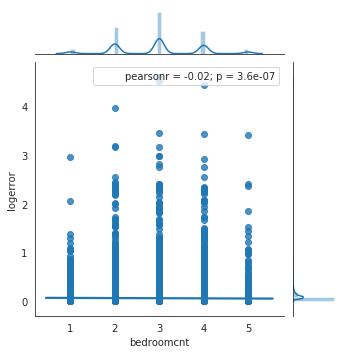

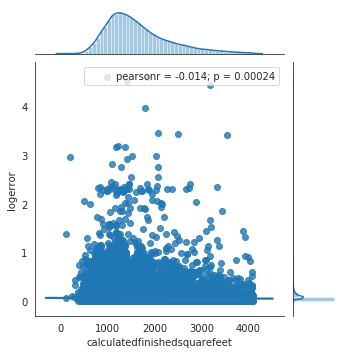

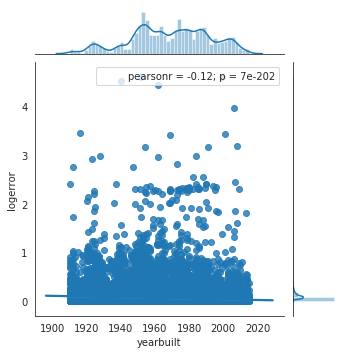

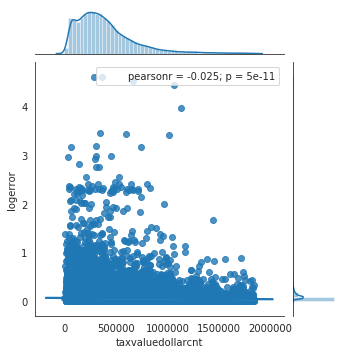

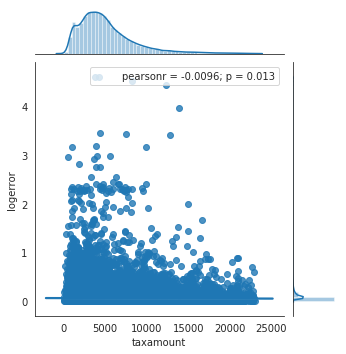

In [33]:
plt.figure(figsize=(10, 5))
with sns.axes_style("white"):
    for i, col in enumerate(x_vars):
        # plt.subplot(3, 1, i + 1)
        j = sns.jointplot(X_train[col], y_train, kind="reg", height=5)
        j.annotate(stats.pearsonr)
plt.show()

1. Looks like bathroomcnt has some relationship with logerr
2. bedroomcnt has a similar relationship. Are they supplying the same information?
3. calculatedfinishedsquarefeet is funnel shaped. 
4. There appears to be no relationship between yearbuilt and logerr
5. taxvaluedollarcnt is funnel shapped. Looks like bigger error occurs with cheaper homes
6. taxamount and taxvaluedollarcnt look very similar. they may be supplying the same information

**Feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent).**

You may want to use a normalized dataframe (if you did that) or adjust the axis scale (set to logarithmic, e.g) so you can more clearly view the interactions.

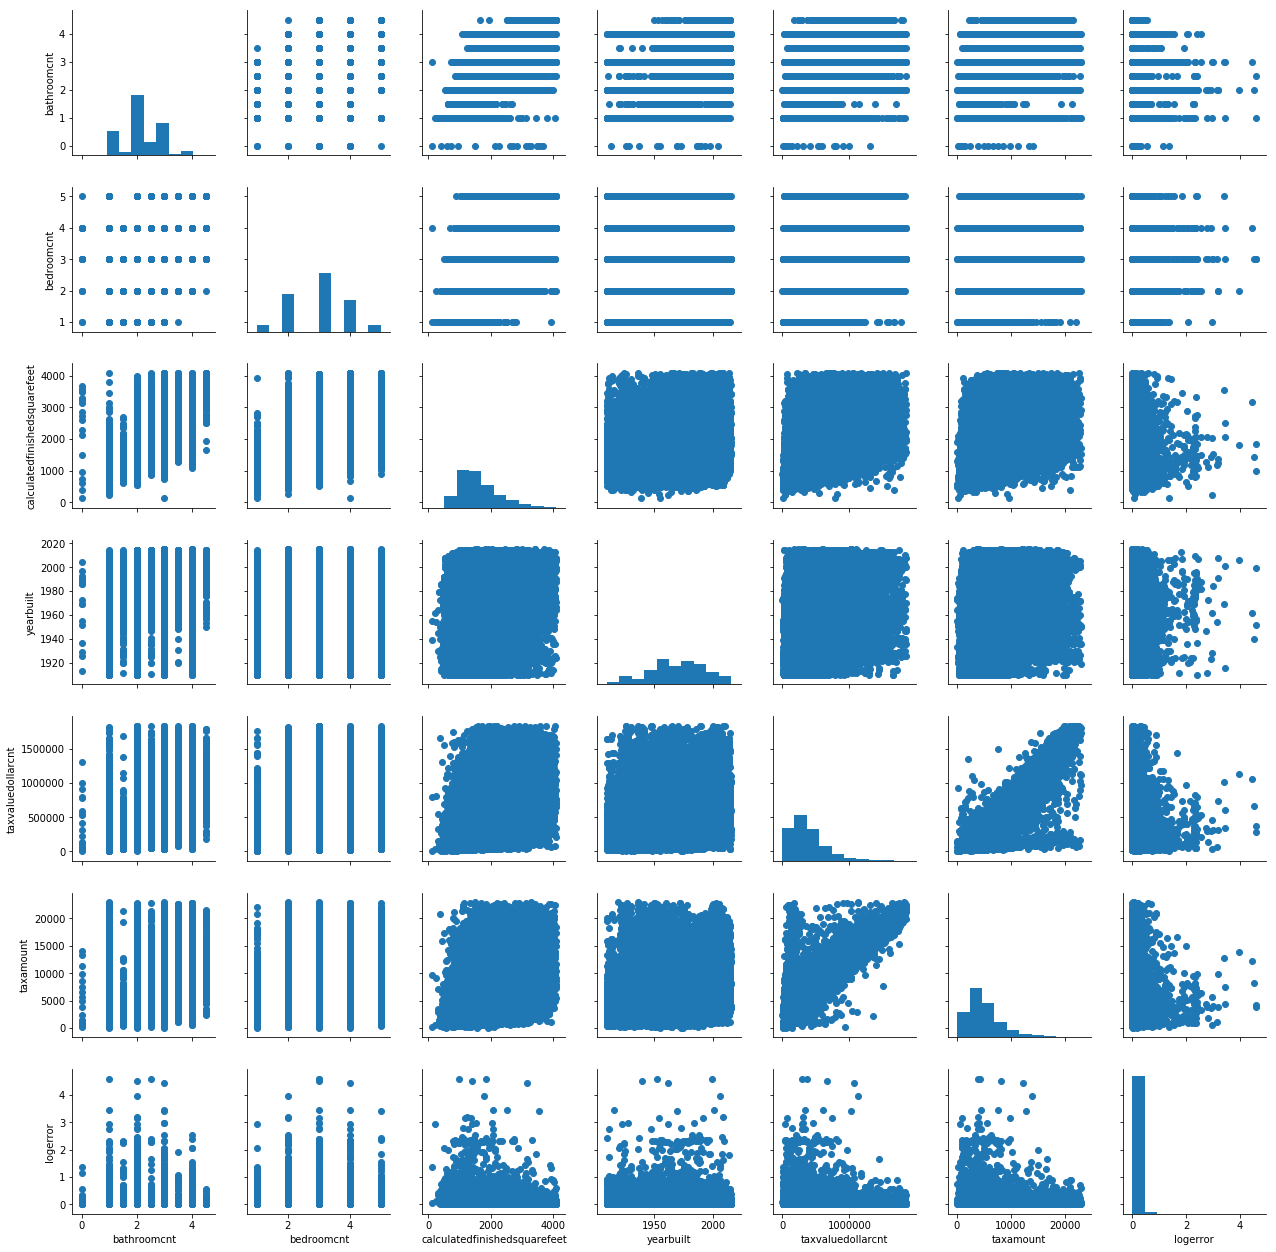

In [34]:
pg = sns.PairGrid(pd.concat([X_train, y_train], axis=1))
pg.map_diag(plt.hist)
pg.map_offdiag(plt.scatter)
plt.show()

1. calculatedfinishedsquarefeet and bathroomcnt appear to have a positive linear relationship.
1. taxvaluedollarcnt and taxamount appear to have a strong positive linear relationship. (these may be giving the same information)
1. Nothing else appears to have a discernable relationship.

**Create a heatmap of the correlation between each variable pair.**

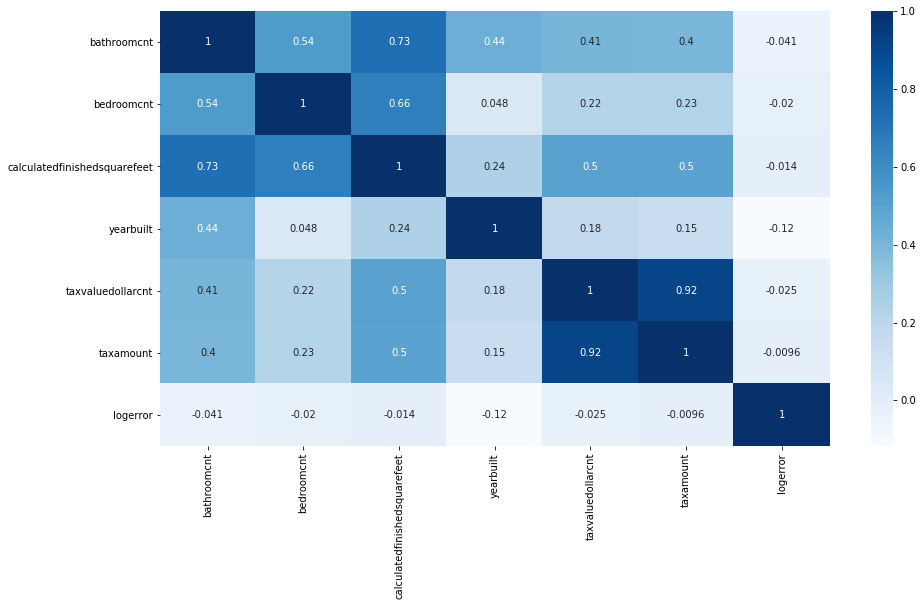

In [35]:
plt.figure(figsize=(15, 8))
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(), cmap="Blues", annot=True)
plt.show()

In [52]:
# Look at the Pearson's R
r_and_p_values = {col: stats.pearsonr(X_train[col], y_train) for col in x_vars}
print("PEARSON'S R WITH total_charges")
for k, v in r_and_p_values.items():
    col = k
    r, p = v
    print(f"{col}:")
    print(f"\tPearson's R is {r:.2f} with a significance p-value of {p: .3}\n")

PEARSON'S R WITH total_charges
bathroomcnt:
	Pearson's R is -0.04 with a significance p-value of  2.14e-26

bedroomcnt:
	Pearson's R is -0.02 with a significance p-value of  3.64e-07

calculatedfinishedsquarefeet:
	Pearson's R is -0.01 with a significance p-value of  0.000243

yearbuilt:
	Pearson's R is -0.12 with a significance p-value of  7.04e-202

taxvaluedollarcnt:
	Pearson's R is -0.03 with a significance p-value of  4.95e-11

taxamount:
	Pearson's R is -0.01 with a significance p-value of  0.0132



1. Bad p-values, consider removing:
    * bedroomcnt
    * taxvaluedollarcnt
    * taxamount

In [37]:
# all variables
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     2450.
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:22:11   Log-Likelihood:                 37678.
No. Observations:               66558   AIC:                        -7.534e+04
Df Residuals:                   66552   BIC:                        -7.529e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                     -0.0112      0.001    -10.795      0.000      -0.013      -0.009
bedroomcnt                      -0.0018      0.001     -2.244      0.025      -0.003      -0.000
calculatedfinishedsquarefeet  9.821e-06   1.45e-06      6.786      0.000    6.98e-06    1.27e-05
yearbuilt                         4e-05   1.01e-06     39.801      0.000     3.8e-05     4.2e-05
taxvaluedollarcnt             -5.01e-08   4.88e-09    -10.263      0.000   -5.97e-08   -4.05e-08
taxamount                     3.577e-06   3.99e-07      8.968      0.000     2.8e-06    4.36e-06
==============================================================================
Omnibus:                   109643.943   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        114376094.857
Skew:                          10.991   Prob(JB):                         0.00
Kurtosis:                     204.890   Cond. No.                     9.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Summarize your conclusions from all of these steps.**

**Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms?**

Null hypothesis: There is no difference in logerror between houses with 3 bedrooms and houses with 5 or more bedrooms
Alternative hypothesis: There is a difference in logerror between the two groups of houses

I would reject the null hypothesis and conclude that there is a significant difference in logerror between the two groups.

In [38]:
def indep_t_test(a: np.ndarray, b: np.ndarray):
    N = len(a) if len(a) == len(b) else 0  # trigger ZeroDivision error
    ## Calculate the Standard Deviation
    #Calculate the variance to get the standard deviation

    #For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
    var_a = a.var(ddof=1)
    var_b = b.var(ddof=1)

    #std deviation
    s = np.sqrt((var_a + var_b) / 2)
    print(f"Standard deviation of the 2 groups: {s}")

    ## Calculate the t-statistics
    t = (a.mean() - b.mean())/(s * np.sqrt(2 / N))

    ## Compare with the critical t-value
    #Degrees of freedom
    df = 2 * N - 2

    #p-value after comparison with the t 
    p = 1 - stats.t.cdf(t, df=df)

    print("t = " + str(t))
    print("p = " + str(2 * p))
    ### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.

    ## Cross Checking with the internal scipy function
    t2, p2 = stats.ttest_ind(a, b)
    print("t = " + str(t2))
    print("p = " + str(p2))
    
df_train = pd.concat([X_train, y_train], axis=1)
three_beds = df_train[df_train.bedroomcnt == 3].logerror
five_plus_beds = df_train[df_train.bedroomcnt >= 5].logerror
# indep_t_test(three_beds.values, five_plus_beds.values)
print(stats.ttest_ind(three_beds.values, five_plus_beds.values))

Ttest_indResult(statistic=-2.5504669199275893, pvalue=0.010762695810293675)


**Run a t-test to test this difference.**

**Do the same for another 2 samples you are interested in comparing (e.g. those with 1 bath vs. x baths)**

There is a significant difference in logerror between those houses with one bathroom and those with three bathrooms

In [39]:
# 1 bathroom v. 3 bathrooms
one_bath = df_train[df_train.bathroomcnt == 1].logerror
three_bath = df_train[df_train.bathroomcnt == 3].logerror
# indep_t_test(three_beds.values, five_plus_beds.values)
print(stats.ttest_ind(one_bath.values, three_bath.values))

Ttest_indResult(statistic=13.85193347955584, pvalue=1.7468739205350248e-43)


There is a significant difference in logerror between those houses with 500-2500 square feet and those with 3500+ square feet

In [40]:
# 500-2500 square feet
# 3500+ square feeet
small_footage = df_train[
    (df_train.calculatedfinishedsquarefeet >= 500) &
    (df_train.calculatedfinishedsquarefeet <= 2500)
].logerror
large_footage = df_train[df_train.calculatedfinishedsquarefeet >= 3500].logerror
# 
print(stats.ttest_ind(small_footage.values, large_footage.values))

Ttest_indResult(statistic=-2.008889537389122, pvalue=0.044553318472068726)


There is a significant difference in logerror between houses with tax value between 100k-250k and 400k-600k


In [41]:
# 100,000 to 250,000 taxvalue
# 400,000 to 600,000
less_expensive = df_train[
    (df_train.taxvaluedollarcnt >= 100_000) &
    (df_train.taxvaluedollarcnt <= 250_000)
].logerror
more_expensive = df_train[
    (df_train.taxvaluedollarcnt >= 400_000) &
    (df_train.taxvaluedollarcnt <= 600_000)].logerror
# 
print(stats.ttest_ind(less_expensive.values, more_expensive.values))

Ttest_indResult(statistic=13.077557509105198, pvalue=5.6352068550614445e-39)


Fail to reject the null hypothesis that there is a difference in logerror between homes built between 1950 and 1970 and those built between 1990 and 2010


In [42]:
# 1950-1970
# 1990-2010
old = df_train[
    (df_train.yearbuilt >= 1950) &
    (df_train.yearbuilt <= 1970)].logerror
new = df_train[
    (df_train.yearbuilt >= 1990) &
    (df_train.yearbuilt <= 2010)].logerror

print(stats.ttest_ind(new.values, old.values))


Ttest_indResult(statistic=-11.852571135039808, pvalue=2.421647278713001e-32)


## Bin Data

In [ ]:
# pd.DataFrame({'grade': df.math,
#               'group': pd.cut(df.math, 4)})

## Modeling

### Feature Engineering & Selection

#### Are there new features you could create based on existing features that might be helpful?
Come up with at least one possible new feature that is a calculation from 2+ existing variables.

- [ ] have a roomcnt with bedrooms + baths
- [ ] ratio of taxvalue to taxamount

In [50]:
X_train.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt,taxamount
count,66558.000000,66558.000000,66558.000000,66558.000000,6.655800e+04,66558.000000
mean,2.184426,2.958337,1636.224736,1968.776556,3.885034e+05,5101.088231
std,0.760853,0.924363,655.276362,22.825219,2.767789e+05,3364.180930
min,0.000000,1.000000,120.000000,1910.000000,2.200000e+01,49.080000
25%,2.000000,2.000000,1163.000000,1953.000000,1.938390e+05,2804.720000
50%,2.000000,3.000000,1495.000000,1970.000000,3.321530e+05,4402.705000
75%,3.000000,4.000000,1968.000000,1986.000000,5.074142e+05,6495.057500
max,4.500000,5.000000,4091.000000,2015.000000,1.840000e+06,22976.050000


### calculate the mean of yearbuilt and then create a column with distance of yearbuilt from mean

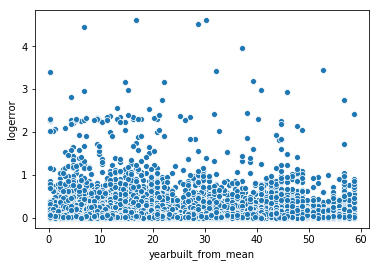

In [49]:
X_train_yb_from_mean = X_train.assign(yearbuilt_from_mean=(X_train.yearbuilt - X_train.yearbuilt.mean()).abs())
sns.scatterplot(x=X_train_yb_from_mean.yearbuilt_from_mean, y=y_train)

In [ ]:
ols_model = sm.OLS(y_train_squared, X_train_plus.taxaccuracy)
fit = ols_model.fit()
fit.summary()

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

In [ ]:
# all variables
ols_model = sm.OLS(y_train_squared, X_train[["bathroomcnt", "calculatedfinishedsquarefeet", "taxamount"]])
fit = ols_model.fit()
fit.summary()

#### Summarize your conclusions and next steps from your analysis in above. 
What will you try when developing your model? (which features to use/not use/etc)

### Train & Test Model

#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

- Make any changes as necessary to improve your model.

- Identify the best model after all training

- Compare the models by plotting the predictions of each model with actual values (see plot right above section 12 in 'Regression in Python' lesson

(the predictions are a 1 x 83 two dimensional matrix, but we want just a single array of predictions. We can use the .ravel method to achieve this.)

`pd.DataFrame({'actual': y_train.final_grade,  
              'lm1': y_pred_lm1.ravel(),  
              'lm2': y_pred_lm2.ravel()})\  
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\  
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')  

plt.plot([60, 100], [60, 100], c='black', ls=':')  
plt.ylim(60, 100)  
plt.xlim(60, 100)  
plt.title('Predicted vs Actual Final Grade')`  

#### Predict & evaluate on out-of-sample data (test)    

- Plot the residuals from your out-of-sample predictions.

- Summarize your expectations about how you estimate this model will perform in production.